## Spectrum Simulation Example

In this example, we will simulate the NMR spectrum of a Pyridine molecule.

- **Molecule and Spins**: The simulation incorporates all NMR active nuclei of the Pyridine molecule.

- **Interactions Included**:
    - **Coherent Interactions**:
        - Zeeman interaction.
        - Chemical shift.
        - Scalar $J$-coupling.
    - **Incoherent Interactions**:
        - Dipolar coupling.
        - Shielding.
        - Quadrupolar interaction.
        - Scalar relaxation of the second kind.

This example provides an overview of how to simulate NMR spectra using Spinguin using its core functionality.

### Imports

To begin, we import all the necessary modules.

- **NumPy**: Used for creating arrays required for input parameters and storing results.
- **Matplotlib**: Utilized for plotting the simulation results.
- **tqdm**: Used to show progress during propagation.
- **Spinguin**: Provides specialized functionality for simulating NMR experiments.

In [14]:
# Import necessary modules:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from spinguin.qm.basis import make_basis
from spinguin.qm.hamiltonian import sop_H_coherent, sop_H_CS, sop_H_Z
from spinguin.qm.relaxation import sop_R_redfield, sop_R_sr2k, ldb_thermalization
from spinguin.qm.states import equilibrium_state, measure
from spinguin.qm.propagation import sop_pulse, sop_propagator, propagator_to_rotframe
from spinguin.utils.nmr_isotopes import ISOTOPES
from spinguin.utils.la import spectrum, frequency_to_chemical_shift

### Simulation Parameters

Next, we define the simulation parameters.

The following experimental conditions are defined:

- **Magnetic Field (T)**: The strength of the static magnetic field $B_0$.
- **Temperature (K)**: The temperature at which the simulation is conducted.

The following acquisition parameters are defined:

- **Dwell Time (s)**: Defines the sampling frequency. Must be set such that the Nyquist criterion is met.
- **Number of Points**: Defines the number of points in the FID. Together with dwell time, determines the total acquisition time.
- **Center Frequencies (ppm)**: Sets the offset of the spectrometer to the specified frequencies. This should be set close to the center of the spectrum.

In [15]:
# Experimental conditions
B0 = 9.4
T = 295

# Acquisition parameters:
dwell_time = 2e-3
npoints = 12500
center_1H = 8
center_14N = 0

### Define the Spin System and Construct the Basis

To define the spin system, we need to specify the following parameters:

- **Spin Quantum Numbers**: An array that contains all the spin quantum number for each spin.
- **Maximum Spin Order**: The maximum entanglement between spins. Limiting the maximum spin order decreases the computational cost.

With these defined, the basis is constructed.

In [16]:
# Define the spin system parameters:
spins = np.array([1/2, 1/2, 1/2, 1/2, 1/2, 1])
max_spin_order = 3
basis = make_basis(spins, max_spin_order)

### Define the Spin System Parameters

We define the following parameters:

- **Gyromagnetic Ratios (rad/s)**: Gyromagnetic ratios for each nucleus.
- **Quadrupolar Moments ($\mathbf{m}^2$)**: Quadrupolar moments for each nucleus. For non-quadrupolar nuclei, these will be zero.
- **Chemical Shifts (ppm)**: The chemical shifts for each nucleus.
- **J Couplings (Hz)**: The $J$-coupling constants between nuclei.
- **XYZ Coordinates (Å)**: The spatial positions of the nuclei in Cartesian coordinates.
- **Shielding Tensors (ppm)**: The nuclear shielding tensors in Cartesian coordinates.
- **EFG Tensors (a.u.)**: The electric field gradient tensors in Cartesian coordinates.
- **Rotational Correlation Time (s)**: The characteristic time for molecular tumbling, affecting relaxation processes.

In [17]:
y1H = 2*np.pi * ISOTOPES['1H'][1] * 10**6
y14N = 2*np.pi * ISOTOPES['14N'][1] * 10**6
gammas = np.array([y1H, y1H, y1H, y1H, y1H, y14N])

q14N = ISOTOPES['14N'][2] * 1e-28
quad = np.array([0, 0, 0, 0, 0, q14N])

chemical_shifts = np.array([8.56, 8.56, 7.47, 7.47, 7.88, 95.94])

J_couplings = np.array([
    [ 0,     0,      0,      0,      0,      0],
    [-1.04,  0,      0,      0,      0,      0],
    [ 4.85,  1.05,   0,      0,      0,      0],
    [ 1.05,  4.85,   0.71,   0,      0,      0],
    [ 1.24,  1.24,   7.55,   7.55,   0,      0],
    [ 8.16,  8.16,   0.87,   0.87,  -0.19,   0]
])

xyz = np.array([
    [ 2.0495335,  0.0000000, -1.4916842],
    [-2.0495335,  0.0000000, -1.4916842],
    [ 2.1458878,  0.0000000,  0.9846086],
    [-2.1458878,  0.0000000,  0.9846086],
    [ 0.0000000,  0.0000000,  2.2681296],
    [ 0.0000000,  0.0000000, -1.5987077]
])

shielding = np.zeros((6, 3, 3))
shielding[5] = np.array([
    [-406.20,  0.00,    0.00],
    [   0.00, 299.44,   0.00],
    [   0.00,   0.00, -181.07]
])

efg = np.zeros((6, 3, 3))
efg[5] = np.array([
    [ 0.3069,  0.0000,  0.0000],
    [ 0.0000,  0.7969,  0.0000],
    [ 0.0000,  0.0000, -1.1037]
])

tau_c = 50e-12

### Calculate Hamiltonian and Relaxation Superoperators

To perform the time evolution of the spin system under the NMR interactions described by the Liouvillian, we need to calculate the following:

- **Hamiltonian**: Represents the coherent interactions in the system.
- **Relaxation Superoperator**: Accounts for the incoherent interactions and the resulting relaxation processes.

The relaxation superoperator is calculated using Redfield theory. The contribution from scalar relaxation of the second kind is added empirically. Ultimately, the relaxation superoperator is thermalized using the Levitt-di Bari convention.

In [18]:
# Calculate the Hamiltonian for the spin system.
H = sop_H_coherent(basis, gammas, spins, chemical_shifts, J_couplings, B0, "comm")

# Calculate the relaxation superoperator for the spin system.
R = sop_R_redfield(basis, H, tau_c, spins, B0, gammas, quad, xyz, shielding, efg)
R = R + sop_R_sr2k(basis, spins, gammas, chemical_shifts, J_couplings, R, B0)
H_left = sop_H_coherent(basis, gammas, spins, chemical_shifts, J_couplings, B0, "left")
R = ldb_thermalization(R, H_left, T)

Constructing Hamiltonian...
Hamiltonian constructed in 0.0112 seconds.

Constructing relaxation superoperator using Redfield theory...
Processing rank l=1, projection q=0
Processing rank l=1, projection q=1
Processing rank l=2, projection q=0
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0
DD for spins 4-1
DD for spins 4-2
DD for spins 4-3
DD for spins 5-0
DD for spins 5-1
DD for spins 5-2
DD for spins 5-3
DD for spins 5-4
CSA for spin 5
Q for spin 5
Processing rank l=2, projection q=1
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0
DD for spins 4-1
DD for spins 4-2
DD for spins 4-3
DD for spins 5-0
DD for spins 5-1
DD for spins 5-2
DD for spins 5-3
DD for spins 5-4
CSA for spin 5
Q for spin 5
Processing rank l=2, projection q=2
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0


### Thermal Equilibrium

To compute the NMR spectrum, we need the thermal equilibrium state.

- The thermal equilibrium state represents the natural distribution of spin populations in the presence of an external magnetic field at a given temperature.
- We create a state vector corresponding to this thermal equilibrium, which serves as the starting point for the simulation.

In [19]:
# Initialize the state vector to thermal equilibrium.
rho = equilibrium_state(basis, spins, H_left, T)

### Apply 90-Degree Pulse

The spectral simulation begins with a 90-degree pulse.

- The 90-degree pulse is applied along the $y$-axis to selected protons (spins with indices 0 to 3).
- This pulse is essentially a rotation operator that tips the magnetization of the selected spins into the transverse plane (towards $x$-axis).
- The pulse is applied by multiplying the state vector with the rotation operator.

In [20]:
# Apply a 90-degree pulse along the y-axis to the protons (spins with indices 0 to 4).
pulse_str = 'I(y,0) + I(y,1) + I(y,2) + I(y,3) + I(y,4)'
pul_90 = sop_pulse(basis, spins, pulse_str, angle=90)

# Update the state vector by applying the 90-degree pulse.
rho = pul_90 @ rho

Creating a pulse superoperator...
Pulse constructed in 0.0074 seconds.



### Construct the Time Propagator

The time propagator is a crucial component for simulating the time evolution of the spin system.

- **Purpose**: The propagator is used to drive the spin system forward in time during the simulation.
- **Construction**: It is constructed using the Hamiltonian and the relaxation superoperator.
- **Time Step**: The propagator is specific to the chosen time step, ensuring accurate simulation of the dynamics.

Note: The simulation is performed in the rotating frame to remove the high-frequency oscillations associated with the bare-nucleus Larmor precession. This involves creating a Hamiltonian that includes the time-independent interactions that cause the high-frequency components.

In [21]:
# Construct the Liouvillian superoperator.
L = -1j*H - R

# Construct the propagator in the rotating frame.
P = sop_propagator(L, dwell_time)
Hz = sop_H_Z(basis, gammas, spins, B0, "comm")
center = np.array([center_1H, center_1H, center_1H, center_1H, center_1H, center_14N])
Hcenter = sop_H_CS(basis, gammas, spins, center, B0, "comm")
H_frame = Hz + Hcenter
P = propagator_to_rotframe(P, H_frame, dwell_time)

Constructing propagator...
Calculating the matrix exponential...
Scaling the matrix down by 16777216.
Calculating the matrix exponential using Taylor series.
Taylor series term: 1
Taylor series term: 2
Taylor series term: 3
Taylor series term: 4
Taylor series term: 5
Taylor series term: 6
Taylor series term: 7
Taylor series term: 8
Taylor series term: 9
Taylor series term: 10
Taylor series term: 11
Taylor series term: 12
Taylor series term: 13
Taylor series term: 14
Taylor series term: 15
Taylor series term: 16
Taylor series term: 17
Taylor series term: 18
Taylor series term: 19
Taylor series term: 20
Taylor series converged.
Squaring the matrix. Step 1 of 24.
Squaring the matrix. Step 2 of 24.
Squaring the matrix. Step 3 of 24.
Squaring the matrix. Step 4 of 24.
Squaring the matrix. Step 5 of 24.
Squaring the matrix. Step 6 of 24.
Squaring the matrix. Step 7 of 24.
Squaring the matrix. Step 8 of 24.
Squaring the matrix. Step 9 of 24.
Squaring the matrix. Step 10 of 24.
Squaring the ma

### Initialize an Empty Array for Storing Results

In this spectrum simulation, we aim to measure the transverse magnetizations of the spins at various time intervals to compute the NMR spectrum.
- **Simulation Approach**: The simulation involves applying a 90-degree pulse and propagating the spin system forward in time. At each time step, the magnetization is "measured" by calculating the expectation value of the specified operator. This corresponds to the quadrature detection.
- **Storage**: To store the magnetizations, we initialize a NumPy array. The array dimension corresponds to the number of time steps in the simulation.

In [22]:
# Initialize an array to store the sum transverse magnetization of the spins.
magnetizations = np.zeros(npoints, dtype=complex)

### Perform the Time Evolution

We are now ready to perform the time evolution of the spin system.

- **Loop Over Time Steps**: Iterate through the total number of time steps defined for the simulation.
- **Propagate the System**: At each time step, propagate the spin system forward in time using the time propagator.
- **Measure Magnetization**: For each proton (spins with indices 0 to 4), measure the total transverse magnetization ($\hat S_- = \hat S_x -i\hat S_y$) and store the results in the `magnetizations` array.

In [23]:
# Define the measurement operator for the simulation.
measurement_str = 'I(-,0) + I(-,1) + I(-,2) + I(-,3) + I(-,4)'

# Perform the time evolution of the spin system with a progress bar.
for step in tqdm(range(npoints), desc="Simulating Time Evolution"):
    
    # Perform the quadrature detection of the transverse magnetization.
    magnetizations[step] = measure(basis, spins, rho, measurement_str)

    # Propagate the state vector to the next time step.
    rho = P @ rho

Simulating Time Evolution: 100%|██████████| 12500/12500 [00:10<00:00, 1148.89it/s]


### Perform the Fourier Transform to Obtain the Spectrum

- **Fourier Transform**: We then take the Fourier transform of the magnetization data to get the NMR spectrum.
- **Consider the Rotating Frame Frequency**: The detection was performed in a rotating frame that involved the high-frequency component arising from bare-nucleus Zeeman interaction and the user-specified center frequency. The rotating frame frequency is added back to the detected frequencies.
- **Frequency to Chemical Shift Conversion**: The frequency axis is converted to chemical shifts in ppm for better interpretability of the spectrum.

In [24]:
# Compute the real part of the spectrum.
freqs, spec = spectrum(magnetizations, dwell_time)

# Calculate rotating frame frequency
center_freq = -y1H * B0 / (2 * np.pi) * (1 + center_1H * 1e-6)

# Add back the rotating frame frequency
freqs = freqs + center_freq

# Set the spectrometer frequency to the Larmor frequency of protons.
freq_spectrometer = -y1H * B0 / (2 * np.pi)

# Convert frequencies to chemical shifts
chemical_shifts = frequency_to_chemical_shift(freqs, freq_spectrometer, freq_spectrometer)

### Plot the Results

Congratulations! The simulation is complete. We will then plot the results.

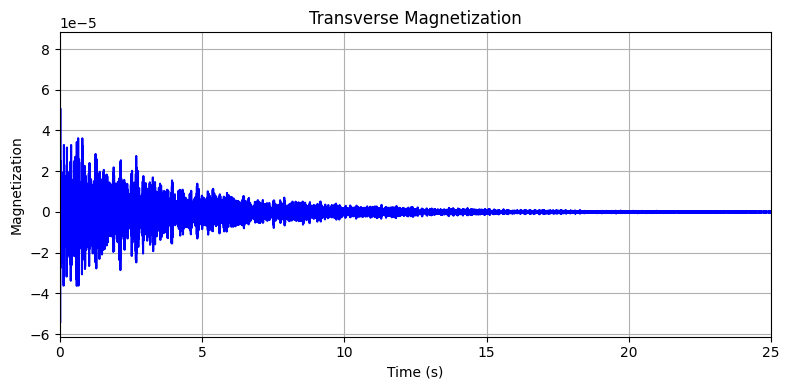

In [25]:
# Plot the magnetization over time
t_axis = np.arange(0, npoints) * dwell_time
plt.figure(figsize=(8, 4))
plt.plot(t_axis, np.real(magnetizations), color='blue')
plt.title('Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.grid()
plt.xlim(0, npoints*dwell_time)
plt.tight_layout()
plt.show()

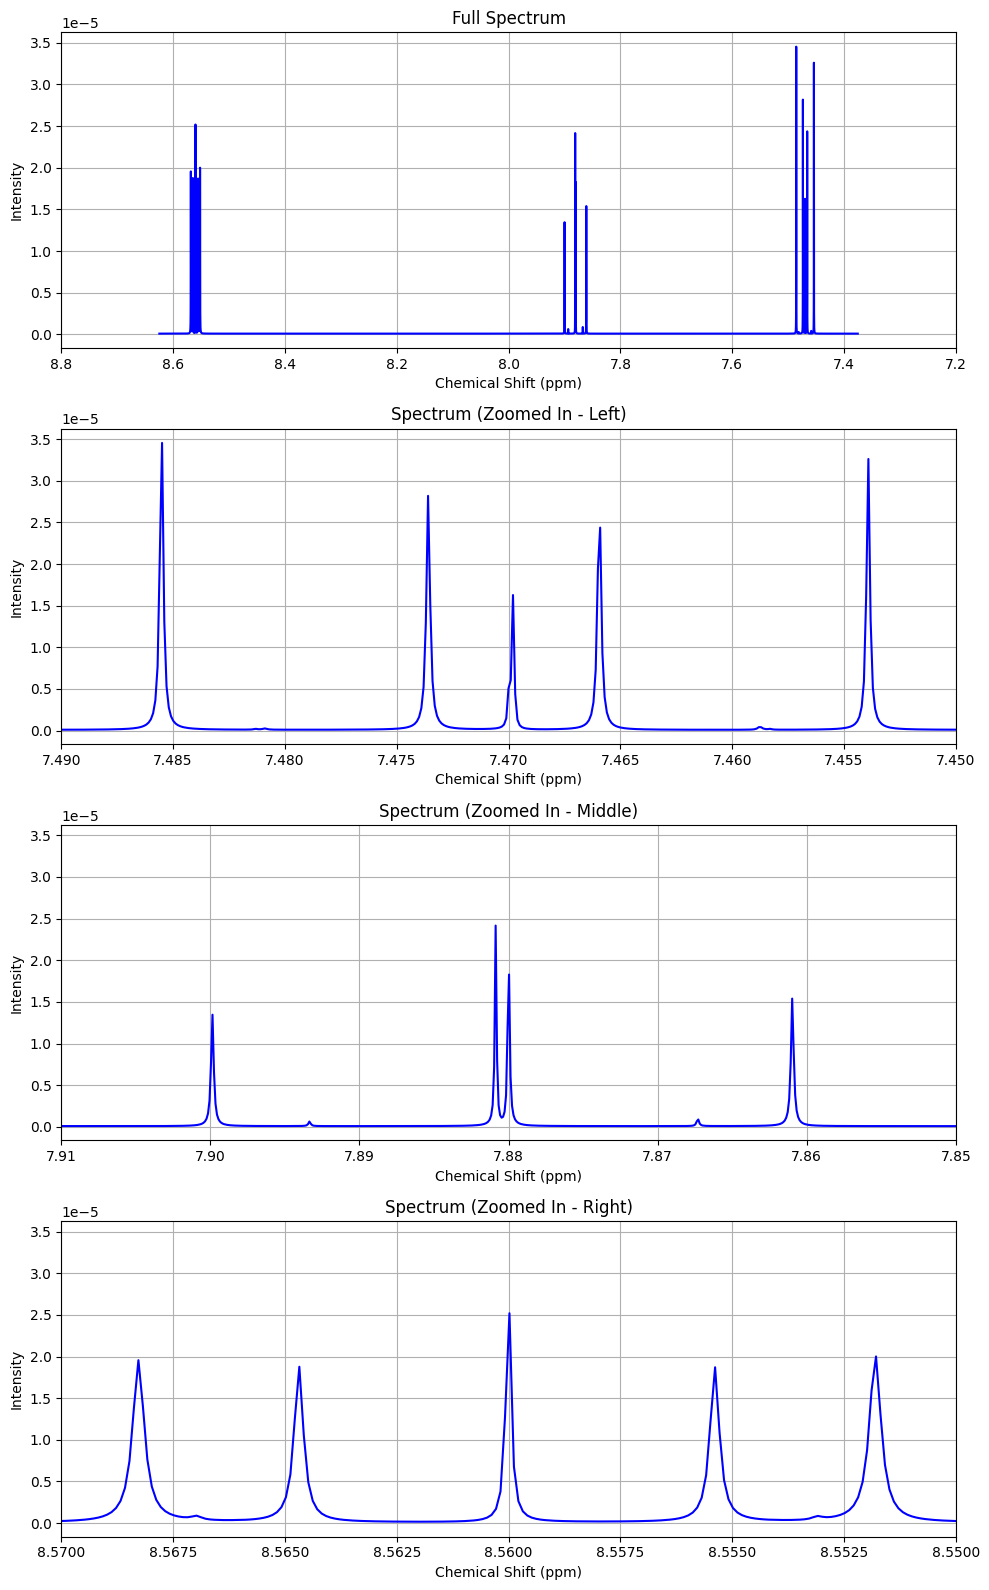

In [26]:
# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

# Plot the full spectrum on the top
axes[0].plot(chemical_shifts, spec, color='blue')
axes[0].set_title('Full Spectrum')
axes[0].set_xlabel('Chemical Shift (ppm)')
axes[0].set_ylabel('Intensity')
axes[0].grid()
axes[0].set_xlim(8.8, 7.2)

# Plot the zoomed-in spectrum (left) in the second subplot
axes[1].plot(chemical_shifts, spec, color='blue')
axes[1].set_title('Spectrum (Zoomed In - Left)')
axes[1].set_xlabel('Chemical Shift (ppm)')
axes[1].set_ylabel('Intensity')
axes[1].grid()
axes[1].set_xlim(7.49, 7.45)

# Plot the zoomed-in spectrum (middle) in the third subplot
axes[2].plot(chemical_shifts, spec, color='blue')
axes[2].set_title('Spectrum (Zoomed In - Middle)')
axes[2].set_xlabel('Chemical Shift (ppm)')
axes[2].set_ylabel('Intensity')
axes[2].grid()
axes[2].set_xlim(7.91, 7.85)

# Plot the zoomed-in spectrum (right) at the bottom
axes[3].plot(chemical_shifts, spec, color='blue')
axes[3].set_title('Spectrum (Zoomed In - Right)')
axes[3].set_xlabel('Chemical Shift (ppm)')
axes[3].set_ylabel('Intensity')
axes[3].grid()
axes[3].set_xlim(8.57, 8.55)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()